# GPU

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
#tf.config.list_physical_devices('GPU')

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="7"
#tf_device='/gpu:0'

In [2]:
import numpy as np
import pandas as pd
import operator
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

allow_growth = True

In [6]:
#images path
img_f_aug_path = "../train_full_aug/"
img_f_path = "../../data/segmented_train/"

img_u_aug_path = "../../heather/augmented_train_unique/"
img_u_path = "../../data/segmented_train_unique_labels/"

#full
df_f_train = pd.read_csv("../CSVinput/df_f_train.csv")
df_f_val = pd.read_csv("../CSVinput/df_f_val.csv")

#unique
df_u_train = pd.read_csv("../CSVinput/df_u_train.csv")
df_u_val = pd.read_csv("../CSVinput/df_u_val.csv")

# Import data

In [7]:
df_f_val

,Unnamed: 0,ID,Label
0,0,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_1,7|0
1,1,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_2,7|0
2,2,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_3,7|0
3,3,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_4,7|0
4,4,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_5,7|0
...,...,...,...
125187,125187,606c3796-bbab-11e8-b2ba-ac1f6b6435d0_19,6
125188,125188,606c3796-bbab-11e8-b2ba-ac1f6b6435d0_20,6
125189,125189,606c3796-bbab-11e8-b2ba-ac1f6b6435d0_21,6
125190,125190,606c3796-bbab-11e8-b2ba-ac1f6b6435d0_22,6


In [8]:
## Check input
df_train_test = df_f_val[:20]
df_val_test = df_f_val[:20]
#df_train_test= df_f_val[125188:125191]

In [9]:
a = df_train_test.ID.values[0]
b = df_train_test.ID.values[19]

In [10]:
imageio.imread(img_f_path + b + "_mt.png" ).shape

(375, 571)

In [11]:
imageio.imread(img_f_path + b + "_mt.png" )

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
input_size = (765, 1250)
type(input_size[0])

int

In [13]:
imageio.imread(img_f_path + a + "_nu.png")

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

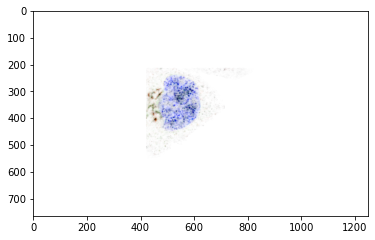

In [14]:
img_mt =tf.keras.preprocessing.image.load_img(img_f_path + a + "_mt.png",color_mode="grayscale") 
img_er =tf.keras.preprocessing.image.load_img(img_f_path + a + "_er.png", color_mode="grayscale") 
img_nu =tf.keras.preprocessing.image.load_img(img_f_path + a + "_nu.png", color_mode="grayscale") 
img_pr =tf.keras.preprocessing.image.load_img(img_f_path + a + "_tp.png", color_mode="grayscale") 

img_4 = np.dstack((img_mt, img_er, img_nu, img_pr))

n_to_add_h = (input_size[0] - img_4.shape[0])
top_pad_h = n_to_add_h//2
bottom_pad_h = n_to_add_h-top_pad_h
                
n_to_add_w = (input_size[1] - img_4.shape[1])
top_pad_w = n_to_add_w//2
bottom_pad_w = n_to_add_w-top_pad_w
                
img_4p = np.pad(img_4, [(top_pad_h, bottom_pad_h), (top_pad_w, bottom_pad_w ), (0,0)], mode = 'constant')
plt.imshow(img_4p)

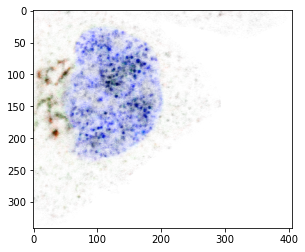

In [15]:
img_mt =tf.keras.preprocessing.image.load_img(img_f_path + a + "_mt.png", color_mode="grayscale") 
img_er =tf.keras.preprocessing.image.load_img(img_f_path + a + "_er.png", color_mode="grayscale") 
img_nu =tf.keras.preprocessing.image.load_img(img_f_path + a + "_nu.png", color_mode="grayscale") 
img_pr =tf.keras.preprocessing.image.load_img(img_f_path + a + "_tp.png", color_mode="grayscale") 

img_4 = np.dstack((img_mt, img_er, img_nu, img_pr))
#tf.image.resize(img_4, (input_size[0], input_size[1]))
plt.imshow(img_4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


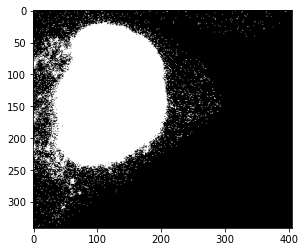

In [16]:
img_test = tf.keras.preprocessing.image.load_img(img_f_path + a + "_nu.png")
plt.imshow(tf.keras.preprocessing.image.img_to_array(img_test))

In [17]:
df_train_test

,Unnamed: 0,ID,Label
0,0,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_1,7|0
1,1,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_2,7|0
2,2,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_3,7|0
3,3,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_4,7|0
4,4,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_5,7|0
5,5,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_6,7|0
6,6,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_7,7|0
7,7,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_8,7|0
8,8,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_9,7|0
9,9,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_10,7|0


In [18]:
lbl = df_train_test.Label.values[0].split('|')
int(lbl[0])
#tf.keras.utils.to_categorical(lbl, num_classes=19)

7

In [19]:
one_hot = np.zeros(19)
print(one_hot)
for i in lbl:
    nmbr = int(i)
    one_hot[nmbr] = 1
one_hot

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

# Generator

In [20]:
df_train_test.head()

,Unnamed: 0,ID,Label
0,0,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_1,7|0
1,1,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_2,7|0
2,2,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_3,7|0
3,3,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_4,7|0
4,4,aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_5,7|0


In [21]:
"""
input =(None(batchsize), input_height, input_width, input_channel)
output= ([batch_size, onhotencoded ])

"""

'\ninput =(None(batchsize), input_height, input_width, input_channel)\noutput= ([batch_size, onhotencoded ])\n\n'

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size, input_size, shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_label = 19
        
        def on_epoch_end(self):  #called by the echt of every epoch by fit method
            if self.shuffle:
                self.df.sample(frac=1).reset_index(drop=True)
        """   def pad(self, img, h, w):
                top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
                bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
                right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
                left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
                
                return np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0))"""
     
        
        def __get_input(self, ID, target_size):  #get inpyt array [batchsize, h, w, input_channel]
            
            #get 4 images
            if os.path.isfile(img_f_path + ID + "_mt.png"):
                img_mt =tf.keras.preprocessing.image.load_img(img_f_path + ID + "_mt.png", color_mode="grayscale") 
                img_mt =tf.keras.preprocessing.image.load_img(img_f_path + ID + "_mt.png", color_mode="grayscale") 
                img_er =tf.keras.preprocessing.image.load_img(img_f_path + ID + "_er.png", color_mode="grayscale") 
                img_nu =tf.keras.preprocessing.image.load_img(img_f_path + ID + "_nu.png", color_mode="grayscale") 
                img_pr =tf.keras.preprocessing.image.load_img(img_f_path + ID + "_pr.png", color_mode="grayscale") 
            else: 
                img_mt =tf.keras.preprocessing.image.load_img(img_f_aug_path + ID + "_mt.png", color_mode="grayscale") 
                img_er =tf.keras.preprocessing.image.load_img(img_f_aug_path + ID + "_er.png", color_mode="grayscale") 
                img_nu =tf.keras.preprocessing.image.load_img(img_f_aug_path + ID + "_nu.png", color_mode="grayscale") 
                img_pr =tf.keras.preprocessing.image.load_img(img_f_aug_path + ID + "_pr.png", color_mode="grayscale") 
                        
            #stack
            img_4 = np.dstack((img_mt, img_er, img_nu, img_pr)).astype(np.float32)
            
            #Padding or resize
            if img_4.shape[0]<= target_size[0] and img_4.shape[1]<= target_size[1]:
                n_to_add_h = (input_size[0] - img_4.shape[0])
                top_pad_h = n_to_add_h//2
                bottom_pad_h = n_to_add_h-top_pad_h
                
                n_to_add_w = (input_size[1] - img_4.shape[1])
                top_pad_w = n_to_add_w//2
                bottom_pad_w = n_to_add_w-top_pad_w
                
                img_4p = np.pad(img_4, [(top_pad_h, bottom_pad_h), (top_pad_w, bottom_pad_w ), (0,0)], mode = 'constant')
            else:
                image_arr = tf.image.resize(img_4, (target_size[0], target_size[1])).numpy()      
                            
            return image_arr/255.
        
        def __get_output(self, label):
            label = str(label)
            lbl = label.split('|')
            one_hot = np.zeros(19, dtype= np.float32)
            for i in lbl:
                one_hot[i] = 1

            return one_hot
        
        def __get_data(self, batches):
            #generates data containing batch_size samples
            
            id_batch = batches[self.X_col['ID']]          #batches ID
            
            label_batch = batches[self.y_col['Label']]    #batches Label
            
            X_batch = np.asarray([self.__get_input(x, self.input_size) for x in zip(id_batch)]) 
            
            y_batch = np.asarray([self.__get_output(y) for y in label_batch])   
            
            return X_batch, y_batch
        
        def __getitem__(self, index):        #generate one batch of data and pass into get_data
            
            batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
            X, y = self.__get_data(batches)
            return X, y
            
        def __len__(self):
            return self.n // self.batch_size  #returns number of batches the generator can produce
            


In [22]:
class CustomDataGen(tf.keras.utils.Sequence):
    """
    This Data generator takes as input a training or validation dataframe and outputs the preprocessed (stacked and same    dimension for every images) in batches with batchsize = 32) 
    """
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col # df["ID"]
        self.y_col = y_col # df["Label"]
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_name = 19

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)


    def __get_input(self, ID, target_size):
        
        path_1 = "../train_full_aug/"
        path_2 = "../../data/segmented_train/"

        if os.path.isfile(path_1+ID+ "_mt.png"): 
            image_mt = tf.keras.preprocessing.image.load_img(path_1+ ID + "_mt.png", color_mode = "grayscale")
            image_nu = tf.keras.preprocessing.image.load_img(path_1+ ID + "_nu.png", color_mode = "grayscale")
            image_er = tf.keras.preprocessing.image.load_img(path_1+ ID + "_er.png", color_mode = "grayscale")
            image_tp = tf.keras.preprocessing.image.load_img(path_1+ ID + "_tp.png", color_mode = "grayscale")
                
        else: 
            image_mt = tf.keras.preprocessing.image.load_img(path_2+ ID + "_mt.png", color_mode = "grayscale")
            image_nu = tf.keras.preprocessing.image.load_img(path_2+ ID + "_nu.png", color_mode = "grayscale")
            image_er = tf.keras.preprocessing.image.load_img(path_2+ ID + "_er.png", color_mode = "grayscale")
            image_tp = tf.keras.preprocessing.image.load_img(path_2+ ID + "_tp.png", color_mode = "grayscale")
        
        # stack the 4 channels 
        img = np.dstack((image_mt, image_nu, image_er, image_tp)).astype(np.float32) 
        
        # pad the images if smaller 
        if img.shape[0]<= target_size[0] and img.shape[1]<= target_size[1]:
                n_to_add_h = (target_size[0] - img.shape[0])
                top_pad_h = n_to_add_h//2
                bottom_pad_h = n_to_add_h-top_pad_h
                
                n_to_add_w = (target_size[1] - img.shape[1])
                top_pad_w = n_to_add_w//2
                bottom_pad_w = n_to_add_w-top_pad_w
                
                image_arr = np.pad(img, [(top_pad_h, bottom_pad_h), (top_pad_w, bottom_pad_w ), (0,0)], mode = 'constant', constant_values=0)
        # resize the images if bigger
        else: 
            image_arr = tf.image.resize(img,(target_size[0], target_size[1]))

        return image_arr/255.


    def __get_output(self, label):
        #return self.one_hot(label)
    
        y_label = label.split('|')
        one_hot = np.zeros(19)
        for i in y_label:
            nmbr = int(i)
            one_hot[nmbr] = 1
        
        return one_hot
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        id_batch = batches[self.X_col['ID']]

        label_batch = batches[self.y_col['Label']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in id_batch])

        y_batch = np.asarray([self.__get_output(y) for y in label_batch])

        return X_batch, y_batch

    def __getitem__(self, index):

        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size


In [23]:
#images path
img_f_aug_path = "../train_full_aug/"
img_f_path = "../../data/segmented_train/"

df_f_train = pd.read_csv("../CSVinput/df_f_train.csv")
df_f_val = pd.read_csv("../CSVinput/df_f_val.csv")

# Hyperparameters
target_size_f = (583, 915)
train_batch_size = 32
val_batch_size = 32

RESCALING_FACTOR = 1./255

# instantiate data generators
datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

#Data generators
traingen = CustomDataGen(df_f_train,
                         X_col = {'ID': 'ID'},
                         y_col = {'Label': 'Label'},
                         batch_size = train_batch_size,
                         input_size = target_size_f)

valgen = CustomDataGen(df_f_val,
                       X_col = {'ID': 'ID'},
                       y_col = {'Label': 'Label'},
                       batch_size = val_batch_size,
                       input_size = target_size_f)

# form steps
train_steps = traingen.n//traingen.batch_size
val_steps = valgen.n//valgen.batch_size

In [25]:

def model_try():
    kernel_size=(3,3)
    pool_size=(4,4)
    first_filters=32
    second_filters=64

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (583, 915, 4)))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(19, activation = 'sigmoid'))

    # compile the model
    model.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    return model 

model1 = model_try() 




input_shape = (583, 915, 4)


inputs = Input(input_shape)

# get the pretrained model, cut out the top layer
pretrained = ResNet50(input_shape = input_shape, include_top=False, input_tensor = inputs, weights='imagenet')

# if the pretrained model it to be used as a feature extractor, and not for
# fine-tuning, the weights of the model can be frozen in the following way
# for layer in pretrained.layers:
#    layer.trainable = False

#output = pretrained(input)
#output = GlobalAveragePooling2D()(output)
#output = Dropout(0.5)(output)
#output = Dense(1, activation='sigmoid')(output)

model = Sequential()
model.add(pretrained)
model.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dropout(.4))
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))      #Adding a dropout layer that will randomly drop 30% of the weights
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(19,activation=('sigmoid')))

#model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(lr=0.001, momentum=0.95), loss = 'category_crossentropy', metrics=['accuracy'])

# print a summary of the model on screen
model.summary() 



from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

#from tensorflow.keras.applications.imagenet_utils import get_submodules_from_kwargs
#from tensorflow.keras.applications.imagenet_utils import decode_predictions
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import models
#from tensorflow.keras.utils import data_utils

#WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    bn_axis = -1

    img_input = Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1_NEW')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = data_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = data_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path, by_name=True)

    elif weights is not None:
        model.load_weights(weights, by_name=True)

    return model

model = ResNet50(input_shape=(583, 915, 4), include_top=False, weights='imagenet')
print(model.summary())

In [28]:
# save the model and weights
model_name = 'Resnet_test'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model1.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# since the model is trained for only 10 "mini-epochs", i.e. half of the data is
# not used during training

model1.fit(traingen, 
            steps_per_epoch=train_steps,
            validation_data=valgen,
            validation_steps=val_steps,
            epochs=10,
            batch_size = 32,
            callbacks=callbacks_list)

Epoch 1/10
   14/17282 [..............................] - ETA: 6:19:31 - loss: 5.3468 - accuracy: 0.0580

KeyboardInterrupt: 

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

In [ ]:
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
inputs = Input((None,None, 4))
classes = 19

model = ResNet50(include_top=False, input_tensor=inputs, weights= None)
for layer in model.layers:
    layer.trainable = False    #Pretrained model is used as feature extractor and not for fine-tuning, the weights of the model are frozen.

X = GlobalAveragePooling2D()(model.output)
X = BatchNormalization()(X)

#output layer
X = Dense(classes, activation = 'softmax', name='RN'+ str(classes))(X)
    
#create model
model = Model(inputs, outputs = X)
model.compile(SGD(lr=0.001, momentum=0.95), loss = loss, metrics=['accuracy'])

model.summary()

# Model